In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('Monthly_subspots.csv', parse_dates = True, index_col = 0).squeeze()

In [2]:
data.head(5)

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
Name: Sunspots, dtype: float64

In [3]:
data['1952']

Month
1952-01-01    40.7
1952-02-01    22.7
1952-03-01    22.0
1952-04-01    29.1
1952-05-01    23.4
1952-06-01    36.4
1952-07-01    39.3
1952-08-01    54.9
1952-09-01    28.2
1952-10-01    23.8
1952-11-01    22.1
1952-12-01    34.3
Name: Sunspots, dtype: float64

<Axes: xlabel='Month'>

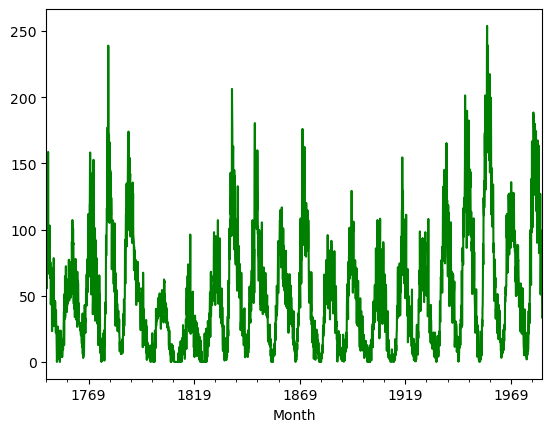

In [4]:
data.plot(color = 'green')

In [5]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
%matplotlib inline

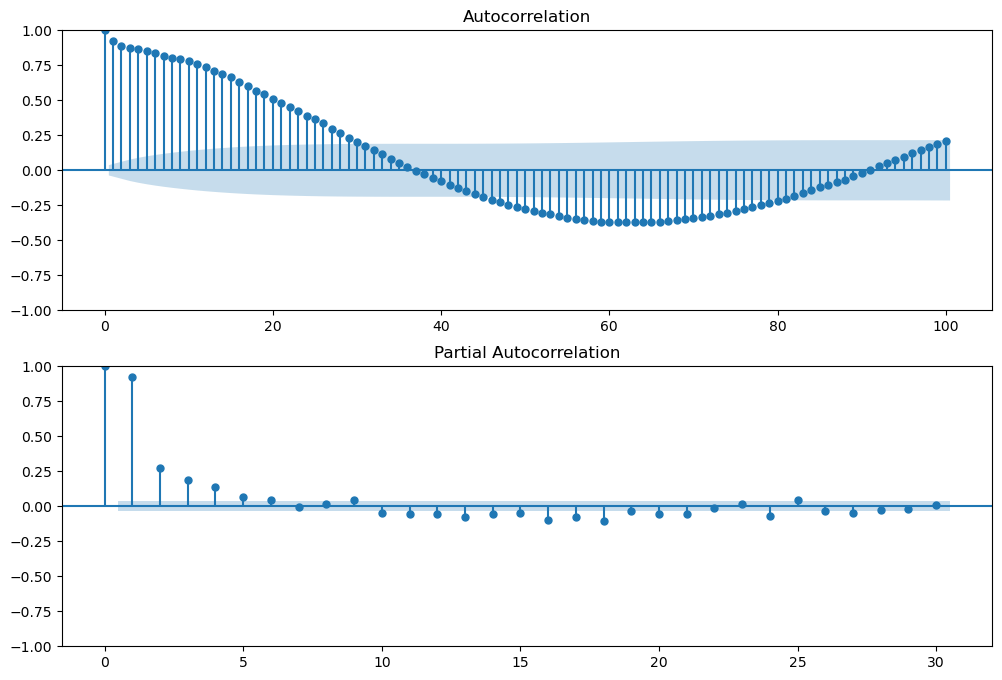

In [6]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=30, ax=ax2)
plt.show()

In [7]:
import warnings
warnings.filterwarnings('ignore')

arma_mod20 = ARIMA(data, order=(2, 0, 0)).fit()
print("ARIMA(2,0,0) Parameters:\n", arma_mod20.params)

ARIMA(2,0,0) Parameters:
 const      51.265857
ar.L1       0.670405
ar.L2       0.272234
sigma2    262.883693
dtype: float64


In [8]:
arma_mod30 = ARIMA(data, order=(3, 0, 0)).fit()
print("ARIMA(2,0,0) AIC, BIC, HQIC:", arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)
print("ARIMA(3,0,0) Parameters:\n", arma_mod30.params)
print("ARIMA(3,0,0) AIC, BIC, HQIC:", arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

ARIMA(2,0,0) AIC, BIC, HQIC: 23724.49959768549 23748.27756634122 23733.079428717447
ARIMA(3,0,0) Parameters:
 const      51.265886
ar.L1       0.619002
ar.L2       0.145725
ar.L3       0.188580
sigma2    253.493317
dtype: float64
ARIMA(3,0,0) AIC, BIC, HQIC: 23624.363978575057 23654.086439394716 23635.088767365003


Durbin-Watson statistic: 2.050317241618253


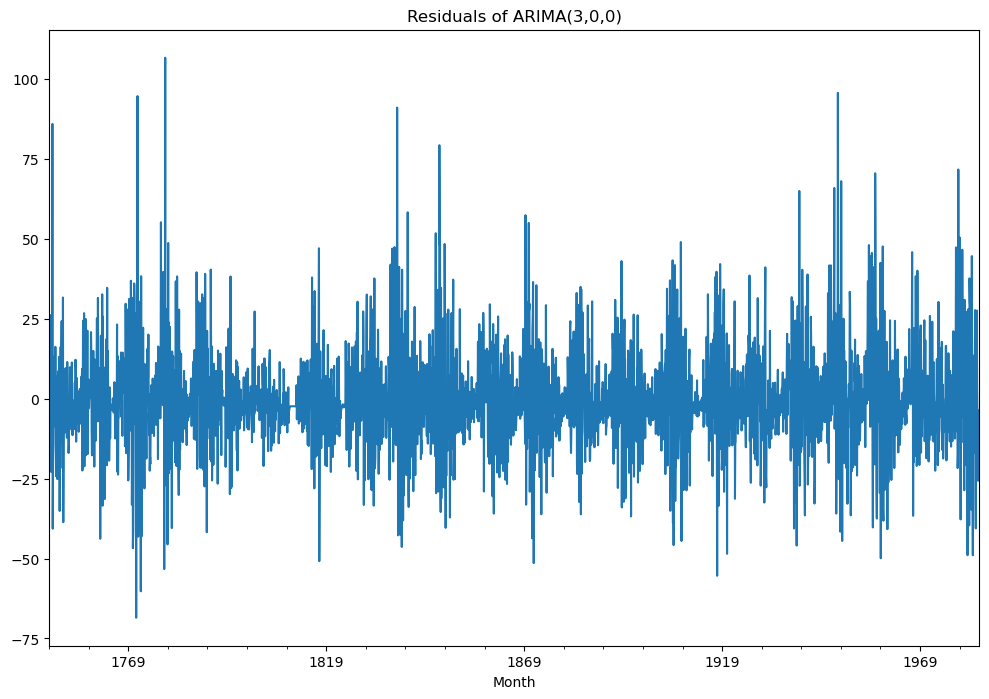

In [9]:
print("Durbin-Watson statistic:", sm.stats.durbin_watson(arma_mod30.resid.values))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax)
plt.title("Residuals of ARIMA(3,0,0)")
plt.show()

In [10]:
resid = arma_mod30.resid
print("Normality test p-value:", stats.normaltest(resid).pvalue)

Normality test p-value: 1.1979705679174238e-92


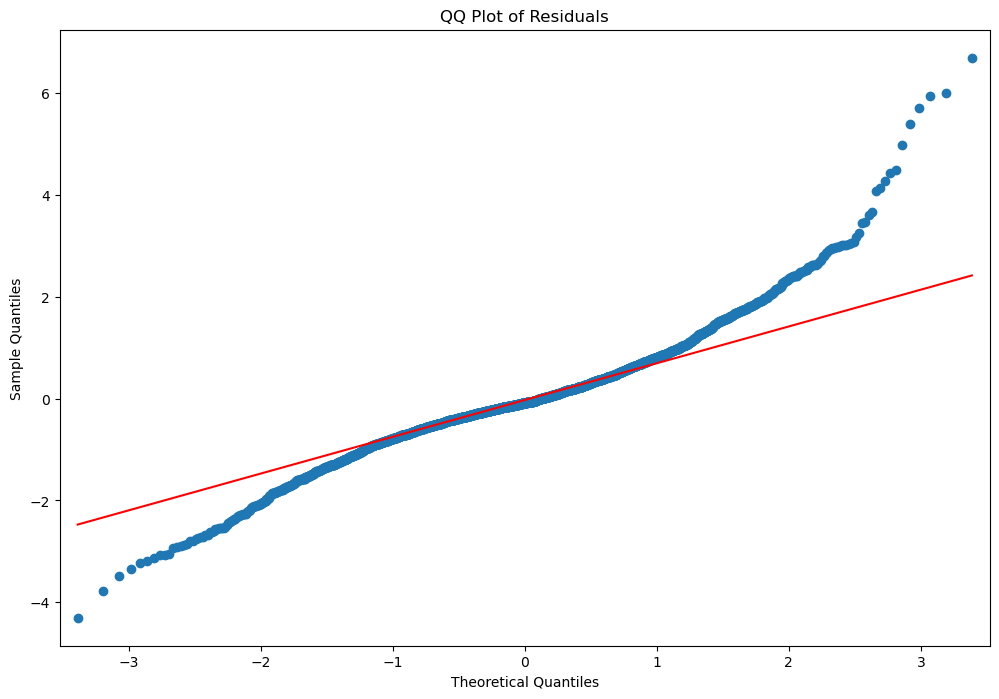

In [11]:
# QQ plot for residuals
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)
plt.title("QQ Plot of Residuals")
plt.show()

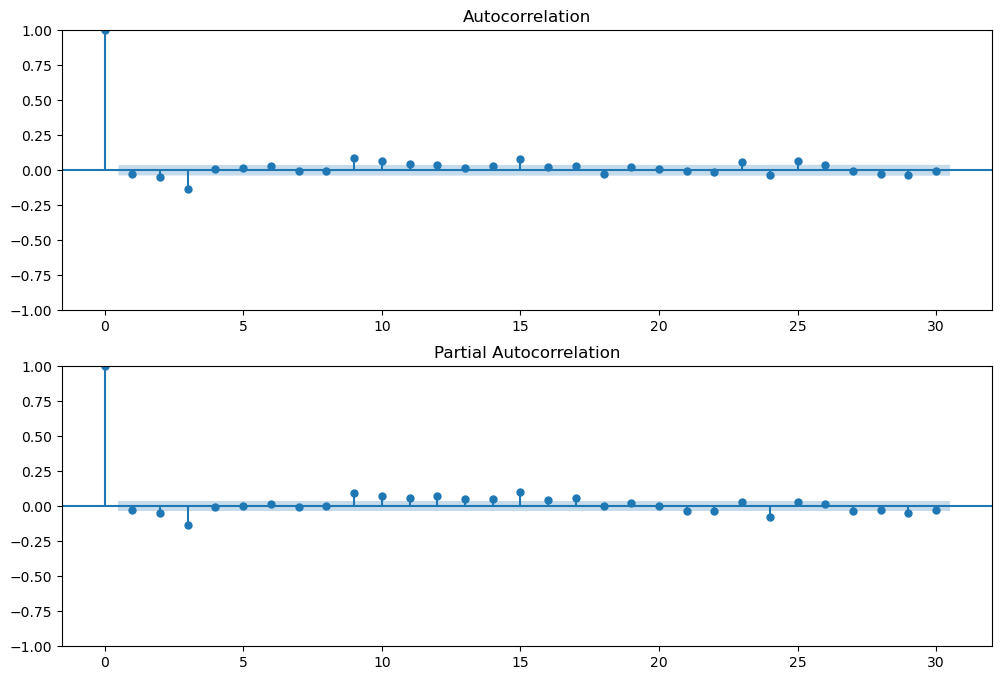

In [12]:
#ACF and PACF residuals
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=30, ax=ax2)
plt.show()

In [13]:
#checks for white noise(no auto correlation)
# Ljung-Box Q-statistic
r, q, p = sm.tsa.acf(resid.values.squeeze(), fft=True, qstat=True)

# Determine the number of lags to use
nlags = min(len(r) - 1, 24)  # Use up to 24 lags or the maximum available

# Create the table
data = np.c_[np.arange(1, nlags + 1), r[1:nlags + 1], q[:nlags], p[:nlags]]
table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
print("Ljung-Box Q-statistic:\n", table.set_index("lag"))

Ljung-Box Q-statistic:
             AC           Q      Prob(>Q)
lag                                     
1.0  -0.025227    1.796586  1.801258e-01
2.0  -0.046409    7.878936  1.945856e-02
3.0  -0.131280   56.566359  3.180343e-12
4.0   0.006280   56.677827  1.445474e-11
5.0   0.017755   57.569000  3.859947e-11
6.0   0.030541   60.206756  4.086042e-11
7.0  -0.006036   60.309835  1.309100e-10
8.0  -0.001892   60.319962  4.033624e-10
9.0   0.089027   82.758416  4.567841e-14
10.0  0.066262   95.193092  4.970797e-16
11.0  0.044392  100.776120  1.253439e-16
12.0  0.034674  104.183426  8.402477e-17
13.0  0.019100  105.217664  1.606225e-16
14.0  0.030489  107.853946  1.457000e-16
15.0  0.078733  125.440571  1.654251e-19
16.0  0.024692  127.171003  2.269779e-19
17.0  0.030568  129.823839  2.026388e-19
18.0 -0.023235  131.357165  2.920307e-19
19.0  0.021801  132.707506  4.473509e-19
20.0  0.007972  132.888129  1.117184e-18
21.0 -0.005297  132.967916  2.841854e-18
22.0 -0.014475  133.563848  5.661

In [14]:
#predicts using ARIMA and find accuracy using MFE
predict_sunspots = arma_mod30.predict("1990", "2012", dynamic=True)
print("Predicted Sunspots (1990-2012):\n", predict_sunspots)

data_series = data[:, 0]  # Replace 0 with the correct column index

# Ensure `predict_sunspots` has the same length as `data_series`
# If `predict_sunspots` is longer, truncate it
if len(predict_sunspots) > len(data_series):
    predict_sunspots = predict_sunspots[:len(data_series)]

# Mean forecast error
def mean_forecast_err(y, yhat):
    return np.mean(y - yhat)

print("Mean Forecast Error:", mean_forecast_err(data_series, predict_sunspots))

Predicted Sunspots (1990-2012):
 1990-01-01    49.685111
1990-02-01    49.732877
1990-03-01    49.779200
1990-04-01    49.824123
1990-05-01    49.867689
                ...    
2011-09-01    51.265344
2011-10-01    51.265360
2011-11-01    51.265376
2011-12-01    51.265392
2012-01-01    51.265407
Freq: MS, Name: predicted_mean, Length: 265, dtype: float64
Mean Forecast Error: -37.62988249472787


Is the ARMA process invertible? True
Is the ARMA process stationary? False


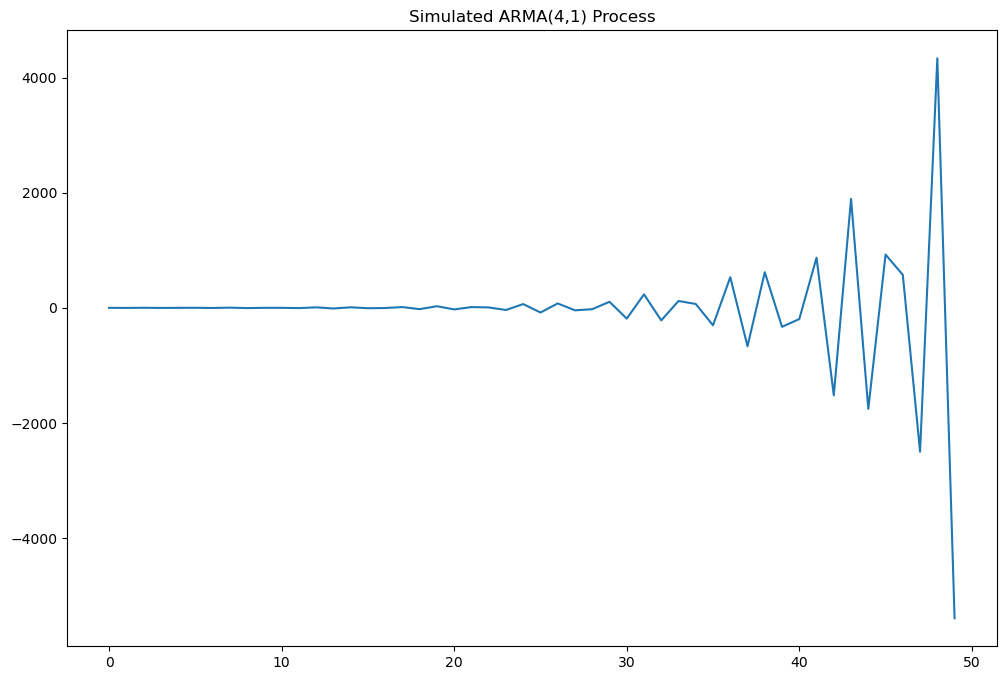

In [15]:
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(1234)
arparams = np.array([1, 0.75, -0.65, -0.55, 0.9])
maparams = np.array([1, 0.65])

arma_t = ArmaProcess(arparams, maparams)
print("Is the ARMA process invertible?", arma_t.isinvertible)
print("Is the ARMA process stationary?", arma_t.isstationary)

# Generate and plot a sample
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(arma_t.generate_sample(nsample=50))
plt.title("Simulated ARMA(4,1) Process")
plt.show()

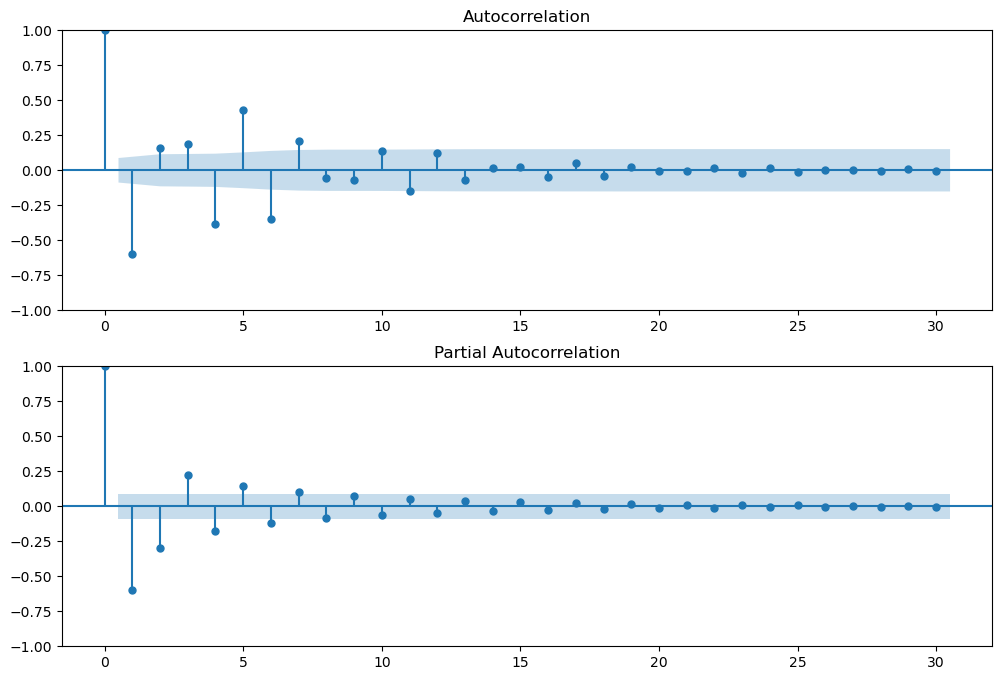

In [16]:
#Fit ARIMA to simulated data
arma_rvs = arma_t.generate_sample(nsample=500, burnin=250, scale=2.5)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_rvs, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_rvs, lags=30, ax=ax2)
plt.show()

In [17]:
arma11 = ARIMA(arma_rvs, order=(1, 0, 1)).fit()
arma41 = ARIMA(arma_rvs, order=(4, 0, 1)).fit()
lags = int(10 * np.log10(len(arma_rvs)))
# Print results
print("ARIMA(1,0,1) Residuals Q-statistic:")
r, q, p = sm.tsa.acf(arma11.resid, nlags=lags, fft=True, qstat=True)
data = np.c_[range(1, lags + 1), r[1:], q, p]
table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
print(table.set_index("lag"))

print("ARIMA(4,0,1) Residuals Q-statistic:")
r, q, p = sm.tsa.acf(arma41.resid, nlags=lags, fft=True, qstat=True)
data = np.c_[range(1, lags + 1), r[1:], q, p]
table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
print(table.set_index("lag"))

ARIMA(1,0,1) Residuals Q-statistic:
            AC           Q       Prob(>Q)
lag                                      
1.0  -0.820851  338.923259   1.094881e-75
2.0   0.489683  459.780927  1.444908e-100
3.0  -0.131677  468.537506  3.137686e-101
4.0  -0.152995  480.382746  1.171046e-102
5.0   0.316104  531.050154  1.580875e-112
6.0  -0.351119  593.690531  5.354212e-125
7.0   0.287966  635.909647  4.484658e-133
8.0  -0.170698  650.774622  2.812854e-135
9.0   0.045284  651.822929  1.560733e-134
10.0  0.054740  653.357837  6.408487e-134
11.0 -0.111419  659.729921  2.296524e-134
12.0  0.123473  667.571338  3.831932e-135
13.0 -0.100874  672.815813  2.216075e-135
14.0  0.059608  674.650841  6.609429e-135
15.0 -0.015486  674.774951  4.401590e-134
16.0 -0.019520  674.972543  2.729052e-133
17.0  0.039312  675.775643  1.217594e-132
18.0 -0.043390  676.756061  4.834423e-132
19.0  0.035353  677.408261  2.190436e-131
20.0 -0.020803  677.634561  1.188798e-130
21.0  0.005297  677.649265  6.967396e-13